# OpenAI taxi problem with Q-Learning

In this Python demo, I will try solving the classic cab-driver problem. The purpose of this notebook is to show how to solve OpenAI Gym environments. I will demonstrate Q-learning on the Taxi environment.

Let's now look at the problem statement.

Here, the objective is to pick up the passenger from one position and drop them off at another in minimum possible time. For this problem, we'll consider our environment to be a 5x5 grid. For the simplicity of the problem, we would not consider any internal obstacles (such as wall).

There are 4 locations (R, G, Y, B) marked in the image. And the task is to pick up the passenger from one of the four locations and drop him off at other. There is a reward of +50 for a successful dropoff, +30 for successful pickup and -5 for every timestep it takes and -15 for illegal pick-up and drop-off actions.

In [1]:
# importing the dependencies

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
pd.options.display.max_rows = 999

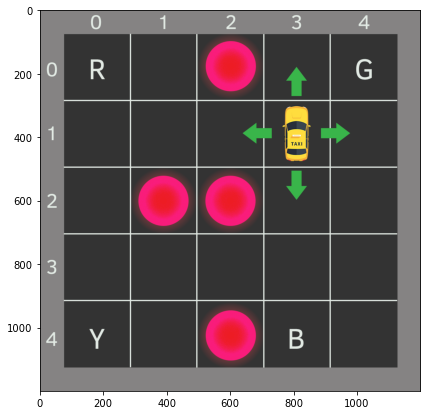

In [2]:
# plotting the problem board

x = plt.imread('/home/kevin/Pictures/Taxi.png')
plt.figure(figsize=(10,7))
plt.imshow(x)
plt.show()

### State Space
The state vector for this problem is (col_index, row_index, destination_locations, passenger_position). The corresponding ranges are as under:

col_index: 0 to 4
row_index: 0 to 4
destination_locations: R-G-Y-B (0 to 3)
passenger_position: R-G-Y-B-Car (0 to 4)


If the passenger is not in cab that means he could be only at one of the four locations. But we also need to account for 1 addition state if the passenger is inside the cab. So, passenger could be at any 4+1 possible locations.

Therefore, the state space = 5x5x4x5 = 500

### Action Space

At any state, the cab driver can either move in any of the four directions or it can pickup/ drop (legally or illegally)

    - 0: south
    - 1: north
    - 2: east
    - 3: west
    - 4: pickup
    - 5: drop


In [3]:
# creating environment

class env:
    
    def __init__(self):
        self.gamma = 0.5 
        self.alpha = 0.5 
        x = product(np.arange(5),np.arange(5),np.arange(4),np.arange(5))
        ind = []
        for i in x:
            ind.append(str(i))
        
        cols = np.arange(6)
        Q_df = pd.DataFrame(data=np.zeros((500,6)), index=ind, columns=cols)
        
        self.q_table = Q_df
        self.epsilon = 0.8

    def random_action(self):
        return np.random.randint(0,6)

    def random_state(self):
        dest_loc = np.random.randint(0,4)    #we should not have same passenger & destination location at start
        pass_loc = np.random.choice(list(set(np.arange(5))-{dest_loc}))
        return tuple([np.random.randint(0,5),np.random.randint(0,5),
               dest_loc,pass_loc])


    def get_next_state(self, s, a):
        s=list(s)
        if a==0:
                if s[0] == 4:
                    return tuple(s), 'NT'
                else:
                    return tuple(np.add(s,(1,0,0,0))), 'NT'
                                 
        elif a==1:
                if s[0] == 0:
                    return tuple(s), 'NT'
                else:
                    return tuple(np.add(s,(-1,0,0,0))), 'NT'
        elif a==2:
                if s[1] == 4:
                    return tuple(s), 'NT'
                else:
                    return tuple(np.add(s,(0,1,0,0))), 'NT'
        elif a==3:
                if s[1] == 0:
                    return tuple(s), 'NT'
                else:
                    return tuple(np.add(s,(0,-1,0,0))), 'NT' 
        elif a==4:
                if s[0]== 0 and s[1]==0 and s[3]==0:
                    s[3]=4
                    return tuple(s), 1
                elif s[0]== 0 and s[1]==4 and s[3]==1:
                    s[3]=4
                    return tuple(s), 1
                elif s[0]== 4 and s[1]==0 and s[3]==2:
                    s[3]=4
                    return tuple(s), 1
                elif s[0]== 4 and s[1]==3 and s[3]==3:
                    s[3]=4
                    return tuple(s), 1
                else:   
                    return tuple(s), 0
        elif a==5:
                if s[3]==4:
                    if s[0]== 0 and s[1]==0 and s[2]==0:
                        s[3]=0
                        return tuple(s), 1
                    elif s[0]== 0 and s[1]==4 and s[2]==1:
                        s[3]=1
                        return tuple(s), 1
                    elif s[0]== 4 and s[1]==0 and s[2]==2:
                        s[3]=2
                        return tuple(s), 1
                    elif s[0]== 4 and s[1]==3 and s[2]==3:
                        s[3]=3
                        return tuple(s), 1
                    else:
                        return tuple(s), 0
                else:   
                    return tuple(s), 0

    
    # There is a reward of +50 for a successful dropoff,
    # +30 for successful pickup,
    # and -5 for every timestep it takes and
    #-15 for illegal pick-up and drop-off actions.
    def get_reward(self, s, a):
        next_state, success = self.get_next_state(s,a)
        if  success==1:
            if a==5:
                return 50
            elif a==4:
                return 30
        elif success==0:
            if a==5:
                return -15
            elif a==4:
                return -15
        elif success=='NT':
            return -5

    def get_next_action(self, ns, er):
        epsilon =  self.epsilon*np.power(1.000001,-er) 
        z = np.random.random()

        if z > epsilon:
            action = np.argmax(self.q_table.loc[str(ns)])   #Exploitation: this gets the action corresponding to max q-value of current state
        else:
            action = self.random_action()    #Exploration: randomly choosing and action

        return action

    def get_next_q_value(self, ns):
        q_max = max(self.q_table.loc[str(ns)].values)
        return q_max
    
    def update_q(self, next_q_value, reward, current_state, current_action):
        existing = self.q_table.loc[str(current_state),current_action]
        updated = existing + self.alpha * (reward + self.gamma*next_q_value - existing)
        self.q_table.loc[str(current_state),current_action] = updated
        return None

In [4]:
# coding for agent to Q-learning

my_env = env()
current_state = my_env.random_state()
current_action = my_env.random_action()
# print('initial state-action', current_state, current_action)
# print(my_env.q_table)


step=0
episode_run = 0
total_episodes = 5000

reward_tracker = []
episode_reward = 0

while episode_run<total_episodes:

    next_state, _ = my_env.get_next_state(current_state, current_action)
#     print('next_state, _',next_state, _)
    reward = my_env.get_reward(current_state, current_action)
#     print('reward',reward)

    next_q_value = my_env.get_next_q_value(next_state)
#     print('next_q_value',next_q_value)

    my_env.update_q(next_q_value, reward, current_state, current_action)

    current_state = next_state
    current_action = my_env.get_next_action(next_state, step)
#     print('current_state, current_action',current_state, current_action)
    
    step+=1
    episode_reward +=reward
    
    
    if reward == 50:   #episode over
        current_state = my_env.random_state()
        current_action = my_env.random_action()
#         print('current_state, current_action',current_state, current_action)
        reward_tracker.append(episode_reward)
        episode_reward = 0
        episode_run+=1
    

In [5]:
df = my_env.q_table

df.rename(columns = {0:'South', 1:'North',
                    2:'East', 3:'West',
                    4:'Pick', 5:'Drop'}, inplace = True)    #assigning action names

df

,South,North,East,West,Pick,Drop
"(0, 0, 0, 0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(0, 0, 0, 1)",-9.423757,-8.847656,-7.695312,-8.847655,-18.847653,-18.847651
"(0, 0, 0, 2)",-7.695312,-8.847656,-9.423827,-8.847656,-18.847635,-18.847213
"(0, 0, 0, 3)",-9.724718,-9.855447,-9.724724,-9.862291,-19.859803,-19.856957
"(0, 0, 0, 4)",5.000000,20.000000,5.000000,20.000000,10.000000,50.000000
"(0, 0, 1, 0)",-0.781250,8.437500,-0.781250,8.437500,26.875000,-1.562500
"(0, 0, 1, 1)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(0, 0, 1, 2)",-7.805176,-8.902503,-9.451215,-8.902583,-18.902498,-18.902577
"(0, 0, 1, 3)",-9.719236,-9.859555,-9.719235,-9.858865,-19.856431,-19.858406
"(0, 0, 1, 4)",-9.062500,-8.125000,-6.250000,-8.125000,-18.125000,-18.125000


### Pickup check:

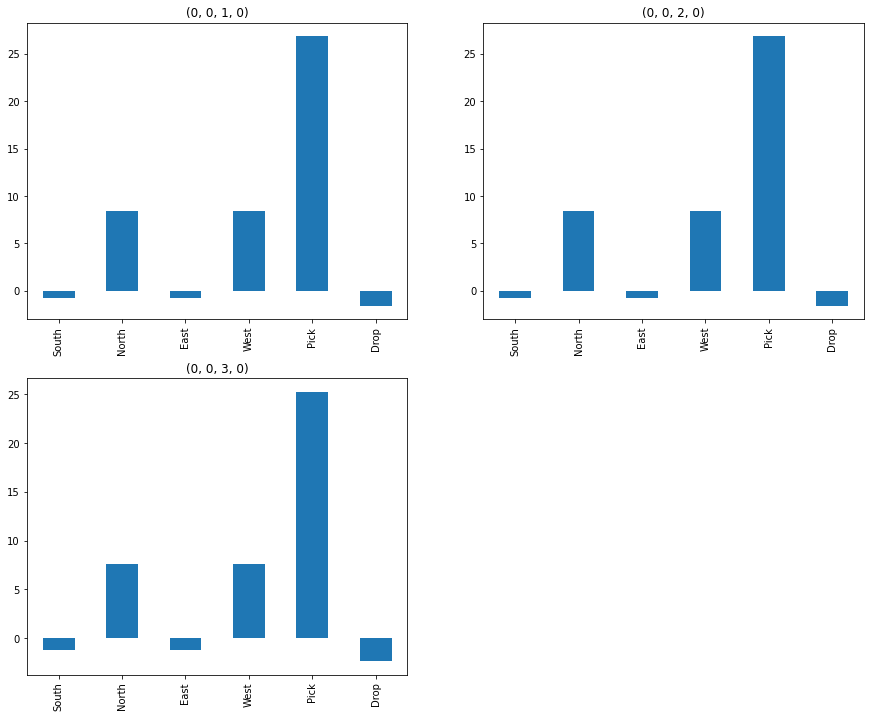

In [6]:
plt.figure(figsize=(15,12))


plt.subplot(2,2,1)
df.loc[str((0,0,1,0))].plot.bar()
plt.title(str((0,0,1,0)))

plt.subplot(2,2,2)
df.loc[str((0,0,2,0))].plot.bar()
plt.title(str((0,0,2,0)))

plt.subplot(2,2,3)
df.loc[str((0,0,3,0))].plot.bar()
plt.title(str((0,0,3,0)))

plt.show()

From above, we note that when location of cab and passenger are same and passenger is not in the cab, the Q value for Pick action is highest.

### Drop check:

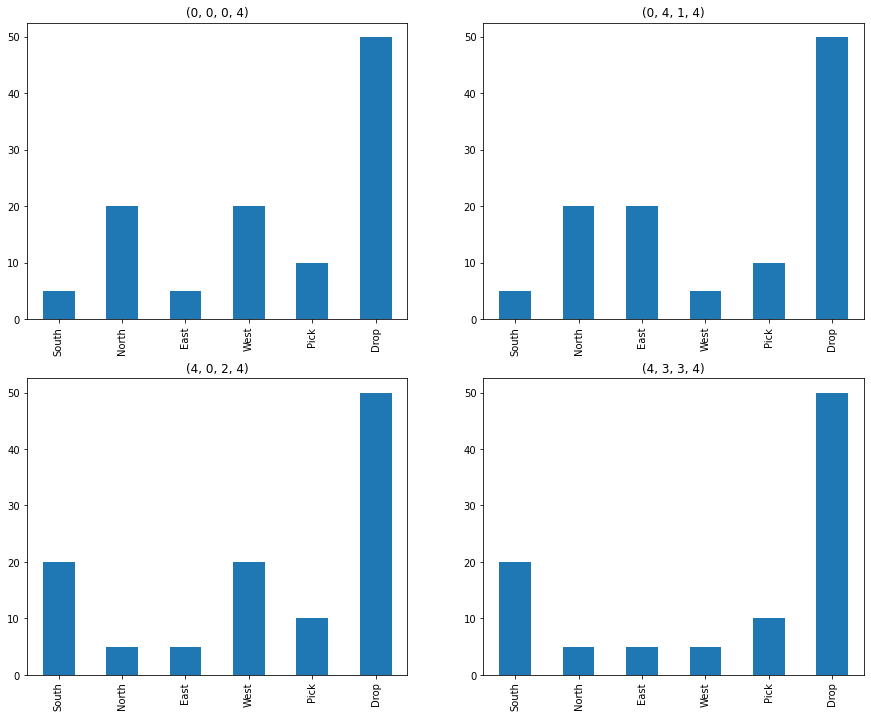

In [7]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
df.loc[str((0,0,0,4))].plot.bar()
plt.title(str((0,0,0,4)))

plt.subplot(2,2,2)
df.loc[str((0,4,1,4))].plot.bar()
plt.title(str((0,4,1,4)))

plt.subplot(2,2,3)
df.loc[str((4,0,2,4))].plot.bar()
plt.title(str((4,0,2,4)))

plt.subplot(2,2,4)
df.loc[str((4,3,3,4))].plot.bar()
plt.title(str((4,3,3,4)))

plt.show()

From above, we note that when location of cab and destination are same and passenger is in the cab, the Q value for Drop action is highest.

### Total-Rewards per episode

In [8]:
max(reward_tracker)

55

The above max value is justifiable since minimum distance between two locations is 4 and hence you must take 4 steps before completing your episode.

Example:
reward = +30-5-5-5-5+50 = 60

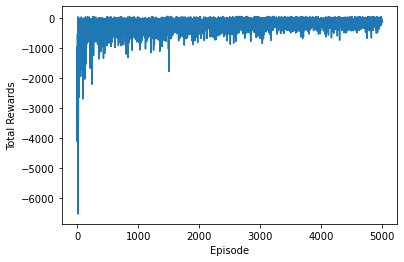

In [9]:
plt.plot(reward_tracker)
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.show()

From above plot, we can clearly note that the total reward per episode is getting converging, as the no. of episodes is increasing. The same shows the successful Q-learning by our agent.

### Epsilon value vs Episode

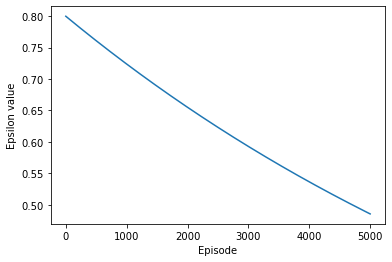

In [10]:
ut = []
for i in range(5000):
    ut.append(0.8*np.power(1.0001,-i))
    
plt.plot(ut)
plt.xlabel('Episode')
plt.ylabel('Epsilon value')
plt.show()

From above, we can justify our choice of epsilon for the given no. of eposode run.

### Conclusion:

From above exercise, we can conclude that with the help of Q-learning, we can teach our agent to solve the simple RL problem in very few episodes.